In [1]:
#!pip install --upgrade pandas numpy scikit-learn imbalanced-learn scipy xgboost seaborn matplotlib

In [2]:
import imblearn
import pandas as pd
import numpy as np
import sklearn
import scipy
import xgboost as xgb

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import HTML

for i in [pd, np, sklearn, scipy, imblearn, xgb, mpl, sns]:
    print(i.__name__, i.__version__)

pandas 0.25.1
numpy 1.18.5
sklearn 0.21.3
scipy 1.5.2
imblearn 0.5.0
xgboost 0.80
matplotlib 3.5.3
seaborn 0.12.2


# 문제 개요

**강사: 멀티캠퍼스 강선구(sunku0316.kang@multicampus.com, sun9sun9@gmail.com)**

DS Lv3 실습 강의 추가 강의 입니다. 

데이터셋을 따로 첨부하지 않겠습니다. git에서 다운로드 받으세요~

[DS_Prob1 Git](https://github.com/sunkusun9/DS_prob1)


**주제: 읽을 도서(to read) 목록을  예측**

유명 도서 전자상거래 회사에서 근무하는 Junior DataScientist 지희는 

읽을 도서(to read)여부 예측하는 모델을 개발하고자 합니다.

각종 데이터를 활용하여 사용자에게 도서를 추천하는 시스템을 구상하고 있습니다.

지희가 도서 추천 프로젝트를 성공적으로 이끌기 위한 미션을 해봅니다.

**데이터셋 구성**

파일명: **books.csv**

도서 정보

|변수명|설명|타입|
|------|----|----|
|book_id|도서 번호|정수형|
|authors|저자|정수형|
|original_title|도서 원제목|문자형|
|pub_year|출간연도|실수형|
|genre|장르|문자형|
|children|유아 가부|정수형|

--------------------------------
파일명: **ratings.csv**

사용자의 도서 평점 데이터 

|변수명|설명|타입|
|------|----|----|
|user_id|사용자 ID|정수형|
|book_id|도서 번호|정수형|
|ratings|평점|정수형|

--------------------------------
파일명: **ratings_test.csv**

사용자의 도서 평점 테스트 데이터

|변수명|설명|타입|
|------|----|----|
|user_id|사용자 ID|정수형|
|book_id|도서 번호|정수형|
|ratings|평점|정수형|

--------------------------------
파일명: **to_read_sample.csv**

사용자별 to_read 도서 목록 샘플

|변수명|설명|타입|
|--|--------------|------|
|user_id|고객 번호|정수형|
|to_reads|도서 번호|문자형: 사용시 '\|'로 구분하여 정수형 리스트로 변환하여 사용|

---------------------------------
파일명: **to_read_kaggle.csv**

kaggle형에서 to_read 목록을 생성해야할 user_id

|변수명|설명|타입|
|--|--------------|------|
|user_id|고객 번호|정수형|


# 데이터 전처리

지희는 읽을 책에는 사용자의 선호도에 기반을 하여 성향을 파악하면 도움이 되리라 생각이 되어, 

사용자의 도서 평점 정보를 활용해 보면 어떨까 생각이 들어 평점 정보를 입수했습니다.

여기서 사용자의 선호도를 추출할 방법을 연구소에 문의한 결과 다음과 같은 가이드를 받았습니다.

-------------------------------

도서 평가데이터에 내재된 사용자별 속성과 도서별 속성을 n차원 실수 벡터로 추출하는 법을 알려 드립니다.

사용자별로 실수 벡터를 모아 (사용자수×n) 행렬로 나타냅니다. 각각의 벡터는 user_id를 통해 접근합니다.

|user_id|$u_0$|$u_1$|$u_1$|...|$u_n$|
|-------|--|--|--|---|--|
|1|0.251|0.1|0.03|...|0.15|
|4|0.08|0.15|0.01|...|0.8|
|...|...|...|...|...|...|
|53394|0.01|0.81|0.12|...|0.92|

※ 위 수치는 실제 수치와는 관계 없습니다.

* Hint user_id를 인덱스로한 pd.DataFrame 구조를 사용하는 것을 권장합니다.

도서별로 실수 벡터를 모아 (도서의 수×n) 행렬로 나타냅니다. 각각의 벡터는 book_id를 통해 접근합니다.

|book_id|$b_0$|$b_1$|$b_1$|...|$b_n$|
|-------|--|--|--|---|--|
|1|0.1|0.128|0.5|...|0.1|
|2|0.07|0.18|0.25|...|0.02|
|...|...|...|...|...|...|
|2355|0.08|0.11|0.02|...|0.05|

※ 위 수치는 실제 수치와는 관계 없습니다.

* Hint book_id를 인덱스로한 pd.DataFrame 구조를 사용하는 것을 권장합니다.


L2 규제(규제 계수 $\lambda$)가 있는 회귀모델 즉, Ridge 회귀모델을 아래의 OLS(Ordinary Least Square)를 통한 회귀계수 구하는 공식을 이용하여

사용자와 도서의 내재된 속성을 추출합니다. 



$\hat{\beta}=(X^TX + \lambda I)^{-1}X^Ty$, 

$X$는 입력 디자인행렬, $y$는 대상변수입니다. $I$는 n×n의 단위행렬(주대각 원소는 1이고 나머지는 0인 행렬)



추출 과정은 아래 **Step A-1~ 5**에서 설명합니다.


연구소에서 검토 결과 이 데이터셋에서는 **$n = 10$, $\lambda = 15$** 을 사용헀을 때, 

시각화를 통해 도서의 성질을 잘 반영하는 결과를 보였다고 합니다. 

구체적인 지표를 제시하지는 않아 미심쩍지만, 이 설정으로 추출을 진행합니다.

-----------------------------------------------


**Step A-1**

ratings.csv를 불러옵니다. (데이터셋 명: **ratings**)

In [3]:
df_ratings = pd.read_csv('ratings.csv')
df_ratings.head()

,user_id,book_id,rating
0,5115,409,5
1,41322,41,5
2,13438,596,3
3,39116,60,3
4,8014,23,4


**Step A-2**

**user_coef**와 **book_coef**를 다음 초기화 루틴에 따라 초기화합니다.

**Step A-1**에서 불러온 **ratings** 데이터프레임의 변수명을 df_ratings로 했을 때, 기준으로 만든 가이드 입니다. 

Python:  user_coef, book_coef 초기화 루틴
```
np.random.seed(123)
n = 10
df_user_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['user_id'].nunique(), n)) * 1 / (n ** 0.5), 
    index=df_ratings['user_id'].unique(),
    columns=['u{}'.format(i) for i in range(10)]
)
df_book_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['book_id'].nunique(), n)) * 1 / (n ** 0.5), 
    index=df_ratings['book_id'].unique(),
    columns=['b{}'.format(i) for i in range(10)]
)
```


In [4]:
np.random.seed(123)
n = 10
# 요건에 따라 사용자들의 성향을 랜덤으로 초기화합니다.
df_user_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['user_id'].nunique(), n)) * 1 / (n ** 0.5), 
    index=df_ratings['user_id'].unique(),
    columns=['u{}'.format(i) for i in range(10)]
)
# 요건에 따라 책들의 성향을 랜덤으로 초기화합니다.
df_book_coef = pd.DataFrame(
    np.random.random(size=(df_ratings['book_id'].nunique(), n)) * 1 / (n ** 0.5), 
    index=df_ratings['book_id'].unique(),
    columns=['b{}'.format(i) for i in range(10)]
)

In [5]:
df_user_coef.head()

,u0,u1,u2,u3,u4,u5,u6,u7,u8,u9
5115,0.220243,0.090485,0.071737,0.174341,0.227516,0.133798,0.310145,0.216562,0.152084,0.123998
41322,0.108522,0.230546,0.138689,0.018872,0.125873,0.233375,0.057709,0.055483,0.168091,0.168179
13438,0.200615,0.268614,0.229093,0.193223,0.228457,0.102129,0.114408,0.072183,0.092881,0.199532
39116,0.029126,0.137148,0.136251,0.156117,0.134659,0.098746,0.134824,0.282514,0.298570,0.158695
8014,0.197311,0.036562,0.100334,0.131180,0.273951,0.079201,0.152749,0.311661,0.164276,0.193814


In [6]:
df_book_coef.head()

,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
409,0.262438,0.097844,0.053097,0.275176,0.274501,0.071009,0.292345,0.165106,0.312427,0.273802
41,0.057463,0.213965,0.302129,0.022355,0.070824,0.292441,0.233511,0.028588,0.280410,0.067130
596,0.276948,0.051862,0.173178,0.110434,0.246806,0.297502,0.069824,0.299641,0.061945,0.024324
60,0.063258,0.256703,0.046376,0.073264,0.087374,0.089428,0.233503,0.265952,0.260564,0.045933
23,0.063401,0.004007,0.277435,0.309319,0.183181,0.051887,0.209688,0.164094,0.214495,0.213498


**Step A-3**

rating을 user_id로 구분합니다. 

구분된 rating셋에서 입력 변수는 **book_coef**행렬에서 book_id에 대응하는 벡터이고, 목적 변수인 rating 변수일 때,

Ridge 회귀모델의 회귀 계수를 위의 공식을 사용하여 구합니다.

예를 들어 user_id 가 1인 rating셋이 아래와 같다면,

|book_id|rating|
|-------|------|
|1|5|
|5|4|
|3|3|
|...|...|
|21|4|

user_id 1에 대한 Ridge 회귀모델을 구하기 위한 Design Matrix는

|$b_0$|$b_1$|$b_2$|...|$b_9$|rating|
|-----|-----|-----|---|-----|------|
|b(1,0)|b(1,1)|b(1,2)|...|b(1,9)|5|
|b(5,0)|b(5,1)|b(5,2)|...|b(5,9)|4|
|b(3,0)|b(3,1)|b(3,2)|...|b(3,9)|3|
|...|...|...|...|...|...|
|b(21,0)|b(21,1)|b(21,2)|...|b(21,9)|4|

가 됩니다. ※ b(i, j): book_coef에서 book_id=i의 j번째 요소입니다

각각의 구분된 rating셋에서 Ridge 회귀모델의 계수를 구하여 user_coef와 동일한 형태의 Matrix를 구합니다.

이를 **user_coef_next**라고 합니다.


Python함수 가이드
```
numpy.dot
numpy.eye
numpy.linalg.inv 활용 권장
```

힌트]


$Δu^2=\sum_{i∈User}{\sum_{j=0}^{j=9}[(u(i,j) - u2(i, j)]^2}$
※ u(i, j): user_coef에서 user_id=i의 j번째 요소입니다.

※ u2(i, j): user_coef_next에서 user_id=i의 j번째 요소입니다

첫 번째 실행 때의 $Δu^2$는 39834.447 (넷째자리 반올림해서 셋째 자리 구함) 입니다.

Ridge 회귀식: $\hat{\beta}=(X^TX + \lambda I)^{-1}X^Ty$, 

In [7]:
# Ridge 회귀계수를 구하는 함수입니다.
lam = 15 * np.eye(n)
def ridge(X, y):
    return np.dot(np.linalg.inv(np.dot(X.T, X) + lam), np.dot(X.T, y))

# user_id별로 평가한 book_id에 대한 book_coef를 가져와서 design matrix를 구성합니다, y는 rating입니다. 
# 이를 ridge에 전달해서 user_coef_next에 대한 사용자별 계수를 구합니다.
df_user_coef_next = df_ratings.groupby('user_id').apply(
    lambda x: pd.Series(
        ridge(df_book_coef.loc[x['book_id']], x['rating']), 
        index=df_user_coef.columns
    )
)
# delta_u^2 입니다.
((df_user_coef_next - df_user_coef) ** 2).sum().sum()

39834.44735835226

**Step A-4**

rating을 book_id로 구분합니다. 

구분된 rating셋에서 입력 변수는 **user_coef_next** 행렬에서 user_id에 대응하는 벡터이고, 목적 변수인 rating 변수일 때, 

Ridge 회귀모델의 회귀 계수를 위의 공식을 사용하여 구합니다.

book_id 가 2인 rating이 아래와 같다면,

|user_id|rating|
|-------|------|
|2|5|
|7|4|
|5|3|
|...|...|
|82|4|

book_id 2에 대한 Ridge 회귀모델을 구하기 위한 Design Matrix는

|$u_0$|$u_1$|$u_2$|...|$u_9$|rating|
|-----|-----|-----|---|-----|------|
|u2(2,0)|u2(2,1)|u2(2,2)|...|u2(2,9)|5|
|u2(7,0)|u2(7,1)|u2(7,2)|...|u2(7,9)|4|
|u2(5,0)|u2(5,1)|u2(5,2)|...|u2(5,9)|3|
|...|...|...|...|...|...|
|u2(82,0)|u2(82,1)|u2(82,2)|...|u2(82,9)|4|

가 됩니다. ※ u2(i, j)는 user_coef_next에서 user_id=i의 j번째 요소입니다

각각의 구분된 rating셋에서 Ridge 회귀모델의 계수를 구하여 book_coef와 동일한 형태의 Matrix를 구합니다.

이를 **book_coef_next**라고 합니다.


힌트]


$Δb^2=\sum_{i∈Book}{\sum_{j=0}^{j=9}[(b(i,j) - b2(i, j)]^2}$

※ b(i, j): book_coef에서 book_id=i의 j번째 요소입니다.

※ b2(i, j): book_coef_next에서 book_id=i의 j번째 요소입니다

첫 번째 실행 후의 $Δb^2$는 389.416 (넷째자리 반올림해서 셋째 자리 구함)입니다. 

In [8]:
# book_id별로 평가한 user_id에 대한 user_coef_next를 가져와서 design matrix를 구성합니다, y는 rating입니다. 
# 이를 ridge에 전달해서 book_coef_next에 대한 책 별 계수를 구합니다.
df_book_coef_next = df_ratings.groupby('book_id').apply(
    lambda x: pd.Series(
        ridge(df_user_coef_next.loc[x['user_id']], x['rating']), 
        index=df_book_coef.columns
    )
)
# delta_b^2입니다.
((df_book_coef_next - df_book_coef) ** 2).sum().sum()

389.4157081697882

**Step A-5**

```
user_coef = user_coef_next
book_coef = book_coef_next
```

으로 설정합니다.

**Step A-3~5**를 **모두 7번을 반복**합니다. 

마지막 실행시, 

$Δu^2$는 62.489, $Δb^2$는 15.764 (넷째자리 반올림해서 셋째 자리 구함) 

입니다.


최종 user_coef와 book_coef를 각각 **user_coef**, **book_coef** 셋이라고 칭합니다.

In [9]:
# 7번 추출과정을 진행합니다.
for i in range(7):
    df_user_coef_next = df_ratings.groupby('user_id').apply(
        lambda x: pd.Series(
            ridge(df_book_coef.loc[x['book_id']], x['rating']), 
            index=df_user_coef.columns
        )
    )
    df_book_coef_next = df_ratings.groupby('book_id').apply(
        lambda x: pd.Series(
            ridge(df_user_coef_next.loc[x['user_id']], x['rating']), 
            index=df_book_coef.columns
        )
    )
    print(
        i + 1, 
        ((df_user_coef_next - df_user_coef) ** 2).sum().sum(), 
        ((df_book_coef_next - df_book_coef) ** 2).sum().sum()
    )
    df_user_coef = df_user_coef_next
    df_book_coef = df_book_coef_next

1 39834.44735835226 389.4157081697882
2 2634.206159906764 218.95561197020476
3 926.6625802543257 86.67844871266773
4 344.6120328321511 44.414709666210214
5 173.38267778892038 29.000772509976496
6 100.11840508703769 20.937716587018283
7 62.488700105216466 15.764150199685647


**Step A-6**

books.csv를 불러옵니다.(데이터셋명: **books**)

In [10]:
df_books = pd.read_csv('books.csv')

**어떤 의미가 있는 지 시각화를 해보고 마무리 합니다.**

**Step 1-7, Optional**

book_coef  데이터셋을 다음과 같은 형식으로 tab으로 분리된 출력 파일 두 개를 만듭니다.

------------------------------------------------------------
**book_coef.tsv**

|$b_0$|$b_1$|$b_2$|...|$b_9$|
|-----|-----|-----|---|----|
|b(1, 0)|b(1, 1)|b(1, 2)|...|b(1, 9)|
|b(2, 0)|b(2, 1)|b(2, 2)|...|b(2, 9)|
|...|...|...|...|...|
|b(2355, 0)|b(2355, 1)|b(2355, 2)|...|b(2355, 9)|


Python 함수 가이드
```
pd.DataFrame.to_csv
sep='\t', header=None, index=None

```
---------------------------------------------------------------
**books.tsv**

|authors|original_title|genre|pub_year|children|
|-------|--------------|-----|--------|--------|
|Suzanne Collins|The Hunger Games|2008.0|Adventure|0|
|J.K. Rowling|Harry Potter and the Philosopher's Stone|1997.0|Fantasy|1|
|...|...|...|...|...|
|George Eliot|Silas Marner: The Weaver of Raveloe|1861.0|Drama|0|

original_title에 결측치는 'Unknown'으로 바꾸어 저장합니다. (books 데이터셋의 내용은 바꾸지 않습니다.)

Python 함수 가이드
```
pd.DataFrame.to_csv
sep='\t', index=None

```
----------------------------------------------------

[Embedding Projector](https://projector.tensorflow.org/)에 접속합니다.

우측에 회색 바탕의 Load 버튼을 클릭하면 

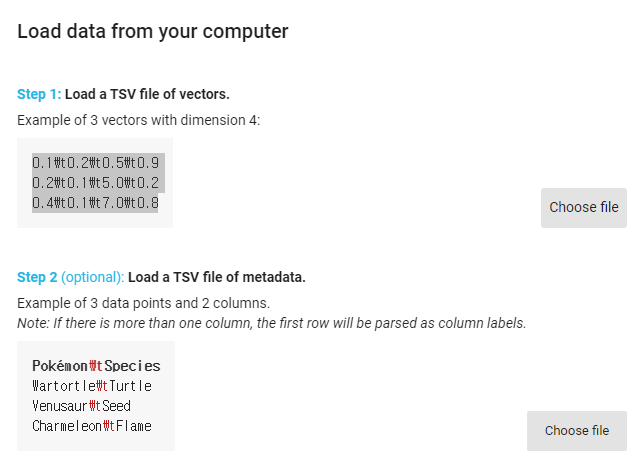

이미지가 뜨는데요, 

Step1에는 book_coef.tsv 

Step2에는 books.tsv

을 전달합니다.

In [11]:
df_book_emb =  df_books.join(df_book_coef, on='book_id')
df_book_emb.head()

,book_id,authors,original_title,pub_year,genre,children,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,1,Suzanne Collins,The Hunger Games,2008.0,Adventure,no,0.138815,-0.389481,1.335726,1.396937,0.837018,-0.180358,1.813663,1.541558,0.622059,-0.149148
1,2,J.K. Rowling,Harry Potter and the Philosopher's Stone,1997.0,Fantasy,Yes,0.917188,-0.565365,0.916848,0.704633,1.913799,0.452515,1.018715,1.668678,-1.240956,1.003572
2,3,Stephenie Meyer,Twilight,2005.0,Romance,no,0.209286,-0.769423,0.596333,0.173773,0.168269,1.272244,-0.254729,3.273716,2.108776,-1.761374
3,4,Harper Lee,To Kill a Mockingbird,1960.0,Mystery,no,1.839442,-0.046629,1.557281,0.352157,0.312667,0.520326,1.461590,0.390590,-0.252235,1.397125
4,5,F. Scott Fitzgerald,The Great Gatsby,1925.0,Romance,no,1.071913,-0.080170,2.220363,-0.161523,0.682047,1.336947,-0.414038,0.105487,-0.059212,2.034095


In [12]:
df_book_emb[df_book_coef.columns].to_csv(
    'book_coef.tsv', sep='\t', header=None, index=None
)

In [14]:
df_book_emb[['authors', 'original_title']].fillna('Unknown').to_csv(
    'books.tsv',
    sep='\t', index=None
)

** Tensorflow embedding project 스크린샷입니다** 
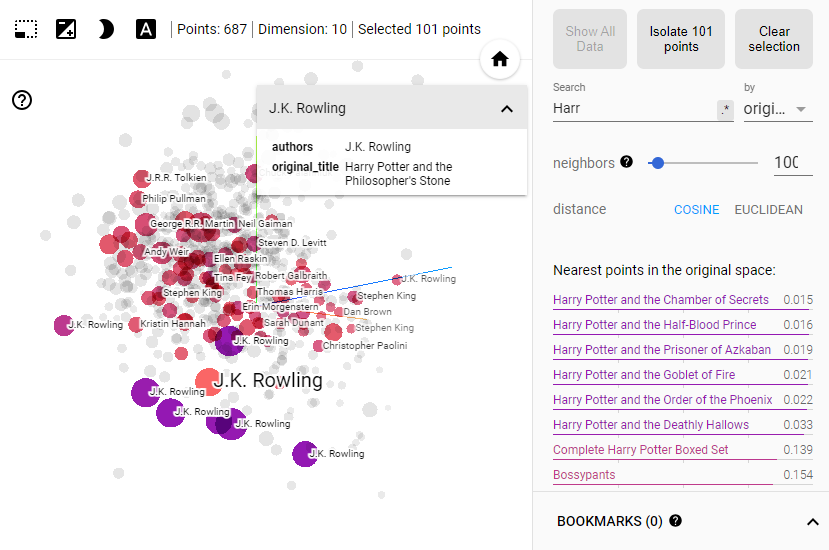